In [1]:
# --- Imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_loader import FootballDataLoader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
# --- Configs ---
data_dir = "/Users/denizadiguzel/FootballData_FromMathias_May2025/RestructuredData_2425"
team = "FCK"
SEQ_LEN = 10
FUTURE_LEN = 20
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-3

In [3]:
# --- Load 1 game ---
loader = FootballDataLoader(data_dir, team)
datasets = loader.load_all_games(
    n_games=1,
    in_play_only=True,
    speed=True,
    z=False,
    use_artificial_players=True,
    every_n=2,
    save=False,
    verbose=(False, False)
)
df = datasets[0]
print("Raw shape:", df.shape)

Reading game 1: Game_LYN_FCK_Score_0_2_Day_2024-07-22Z.pkl
Loading Game_LYN_FCK_Score_0_2_Day_2024-07-22Z.pkl
Data read.
Raw shape: (48274, 95)


In [4]:
# --- Extract and scale ---
ball_cols = ["Ball_x", "Ball_y", "Ball_Speed?"]
player_cols = [f"{team}player_{i}_{k}" for i in range(11) for k in ("x", "y", "speed_x")]
all_cols = ball_cols + player_cols
df = df[all_cols].dropna().reset_index(drop=True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [5]:
# --- Create multistep sequences ---
def create_multistep_sequences(dataframe, seq_len=10, future_len=5):
    data = dataframe.values
    X, y = [], []
    for i in range(len(data) - seq_len - future_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+future_len, 3:])  # only player data
    return np.array(X), np.array(y)

X, y = create_multistep_sequences(df_scaled, SEQ_LEN, FUTURE_LEN)
print("X shape:", X.shape, "| y shape:", y.shape)

# --- Tensors ---
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

X shape: (48244, 10, 36) | y shape: (48244, 20, 33)


In [6]:
# --- Model ---
class PlayerMultiStepLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, future_len):
        super().__init__()
        self.lstm_enc = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm_dec = nn.LSTM(output_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.future_len = future_len

    def forward(self, x):
        batch_size = x.size(0)
        _, (h, c) = self.lstm_enc(x)

        decoder_input = torch.zeros(batch_size, 1, 33, device=x.device)
        outputs = []

        for _ in range(self.future_len):
            out, (h, c) = self.lstm_dec(decoder_input, (h, c))
            pred = self.fc(out.squeeze(1))
            outputs.append(pred.unsqueeze(1))
            decoder_input = pred.unsqueeze(1)

        return torch.cat(outputs, dim=1)  # [batch, future_len, 33]

model = PlayerMultiStepLSTM(input_size=36, hidden_size=64, output_size=33, future_len=FUTURE_LEN)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [7]:
# --- Training ---
for epoch in range(EPOCHS):
    model.train()
    train_loss, val_loss = 0.0, 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            val_loss += criterion(pred, yb).item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1/20 | Train Loss: 0.0190 | Val Loss: 0.0107
Epoch 2/20 | Train Loss: 0.0079 | Val Loss: 0.0076
Epoch 3/20 | Train Loss: 0.0062 | Val Loss: 0.0059
Epoch 4/20 | Train Loss: 0.0052 | Val Loss: 0.0052
Epoch 5/20 | Train Loss: 0.0046 | Val Loss: 0.0050
Epoch 6/20 | Train Loss: 0.0042 | Val Loss: 0.0044
Epoch 7/20 | Train Loss: 0.0040 | Val Loss: 0.0043
Epoch 8/20 | Train Loss: 0.0037 | Val Loss: 0.0039
Epoch 9/20 | Train Loss: 0.0036 | Val Loss: 0.0037
Epoch 10/20 | Train Loss: 0.0035 | Val Loss: 0.0035
Epoch 11/20 | Train Loss: 0.0033 | Val Loss: 0.0035
Epoch 12/20 | Train Loss: 0.0032 | Val Loss: 0.0033
Epoch 13/20 | Train Loss: 0.0032 | Val Loss: 0.0032
Epoch 14/20 | Train Loss: 0.0031 | Val Loss: 0.0044
Epoch 15/20 | Train Loss: 0.0031 | Val Loss: 0.0036
Epoch 16/20 | Train Loss: 0.0030 | Val Loss: 0.0036
Epoch 17/20 | Train Loss: 0.0029 | Val Loss: 0.0031
Epoch 18/20 | Train Loss: 0.0029 | Val Loss: 0.0032
Epoch 19/20 | Train Loss: 0.0028 | Val Loss: 0.0031
Epoch 20/20 | Train L

In [8]:
# --- Visualization ---
def visualize_multistep_predictions(model, val_loader, num_samples=3):
    model.eval()
    with torch.no_grad():
        xb, yb = next(iter(val_loader))
        preds = model(xb)

        for i in range(min(num_samples, xb.shape[0])):
            fig, ax = plt.subplots(figsize=(6, 6))
            for player_id in range(11):
                # True & Predicted trajectory of player `i`
                true_xy = yb[i, :, player_id*3:player_id*3+2].cpu().numpy()
                pred_xy = preds[i, :, player_id*3:player_id*3+2].cpu().numpy()

                ax.plot(true_xy[:, 0], true_xy[:, 1], 'o-', label=f'P{player_id} True', alpha=0.5)
                ax.plot(pred_xy[:, 0], pred_xy[:, 1], 'x--', label=f'P{player_id} Pred', alpha=0.7)

            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_title(f"Multi-step Prediction (Frame {i})")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.grid(True)
            ax.legend(ncol=2, fontsize=8, loc='upper right')
            plt.tight_layout()
            plt.show()

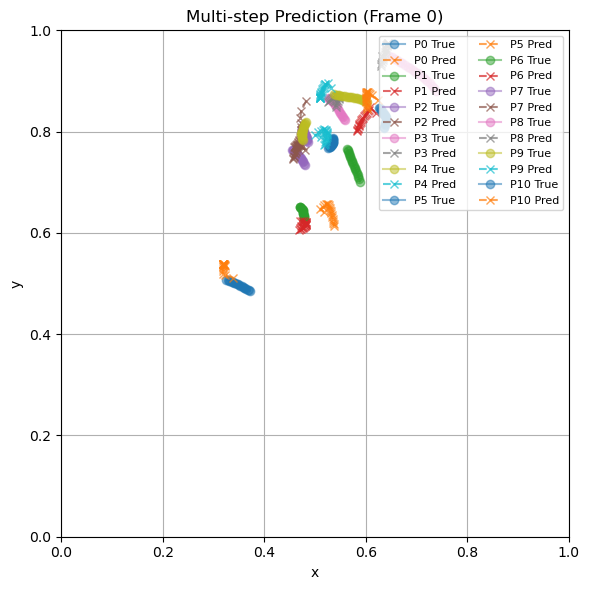

In [10]:

# Show prediction visualizations
visualize_multistep_predictions(model, val_loader, num_samples=1)
